Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [304]:
from random import random, seed
from itertools import accumulate
from itertools import product
import numpy as np
from matplotlib import pyplot as plt

from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [305]:
UNIVERSE_SIZE = 10_000
NUM_SETS = 1000
DENSITY = 0.2

MAX_STEPS = 10_000
rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [306]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [307]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()



## Have Fun!

In [308]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(4279421.81716355))

In [309]:
# A random solution with random 50% of the sets
#solution = rng.random(NUM_SETS) < .5
#valid(solution), cost(solution)

In [310]:
def fitness(solution: np.ndarray):
    return valid(solution), -cost(solution)

In [311]:
#rng.

## SIMPLE RHMC


In [333]:
def single_tweak(solution: np.ndarray) -> np.ndarray:
    new_solution = solution.copy()

    #pos = np.random.randint(NUM_SETS)
    pos = rng.integers(0, NUM_SETS)
    new_solution[pos] = not new_solution[pos]
    
    return new_solution

def multi_tweak(solution: np.ndarray) -> np.ndarray:
    mask = rng.random(NUM_SETS) < .01
    new_solution = np.logical_xor(solution, mask)
    
    return new_solution


ic|

 fitness_solution: (np.True_, np.float64(-2004962.6324576414))
ic| fitness_solution: (np.True_, np.float64(-553821.068511032))


(np.True_, np.float64(-553821.068511032))

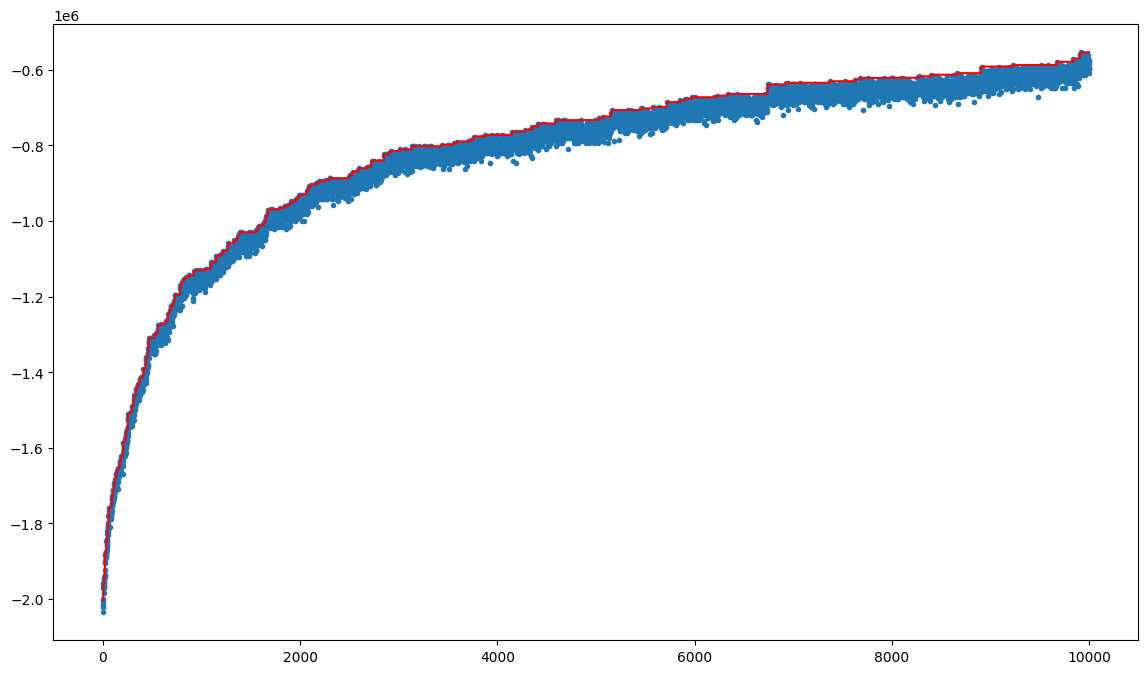

In [335]:
current_solution = rng.random(NUM_SETS) < 0.5
fitness_solution = fitness(current_solution)
history = [float(fitness_solution[1])]
ic(fitness_solution)

steps =  0

#tweak = single_tweak
tweak = multi_tweak
for steps in range(MAX_STEPS):
    

    #tweak  
    new_solution = tweak(current_solution)   
    f = fitness(new_solution)
    history.append(float(f[1]))
    if(f> fitness_solution):
       # ic(steps, cost(current_solution), cost(new_solution))
        fitness_solution = fitness(new_solution)
        current_solution = new_solution
   

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")


ic(fitness_solution)

## improved RHMC with Stength

In [314]:
def multi_tweak_strength(solution: np.ndarray, strength: float = 0.3) -> np.ndarray:
    mask = rng.random(NUM_SETS) < strength
    if (not np.any(mask)): #if all false add 1 true
        mask[np.random.randint(NUM_SETS)] = True

    new_solution = np.logical_xor(solution, mask)
    
    return new_solution


ic

| fitness_solution: (np.True_, np.float64(-2291401.3555666627))
ic| history.index(max(history)): 6344
ic| fitness_solution: (np.True_, np.float64(-123881.45931147327))


(np.True_, np.float64(-123881.45931147327))

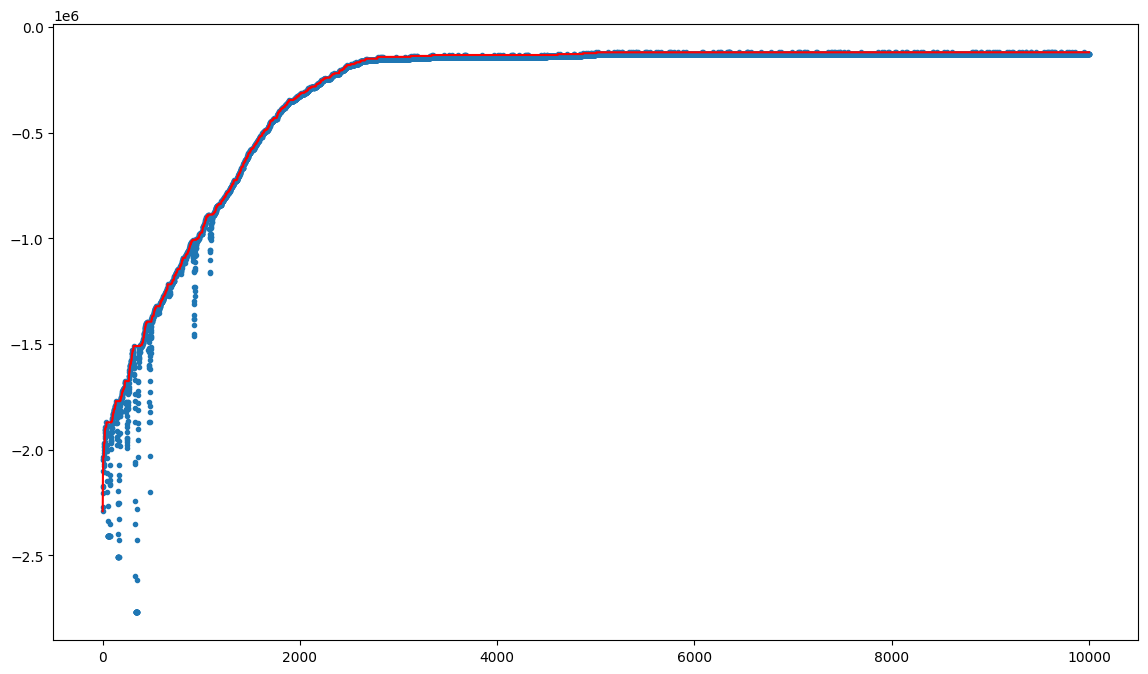

In [323]:
BUFFER_SIZE = 50 #rule 1/5

current_solution = rng.random(NUM_SETS) < 0.5
fitness_solution = fitness(current_solution)
history = [float(fitness_solution[1])]
ic(fitness_solution)

strength = 0.5
buffer  = list()


for steps in range(MAX_STEPS):
    #SEELF ADAPTIVE
#    if steps % 1000:
#       strength /= 2

    #tweak  
    new_solution = multi_tweak_strength(current_solution, strength)   
    f = fitness(new_solution)
    history.append(float(f[1]))
    buffer.append(f > fitness_solution)
    #take only the last BUFFER_SIZE elements
    buffer = buffer[-BUFFER_SIZE:]
    #if the fitness increased by 12% increase strength
    if (sum(buffer) > 10):
        strength *= 1.2
    elif (sum(buffer) < 10 ):
        strength /= 1.2

    if(f> fitness_solution):
       # ic(steps, cost(current_solution), cost(new_solution))
        fitness_solution = fitness(new_solution)
        current_solution = new_solution
   

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

ic(history.index(max(history)))
ic(fitness_solution)

## my RHMC

In [336]:
def tweak(solution):
    new_solution = solution.copy()
    index = None
    while index is None or np.random.random() < 0.2:
        index = np.random.randint(0, NUM_SETS)
        new_solution[index] = not new_solution[index]
    return new_solution


ic| cost(current_solution): np.float64(2151497.093869569)


(np.True_, np.float64(135579.00880800548))

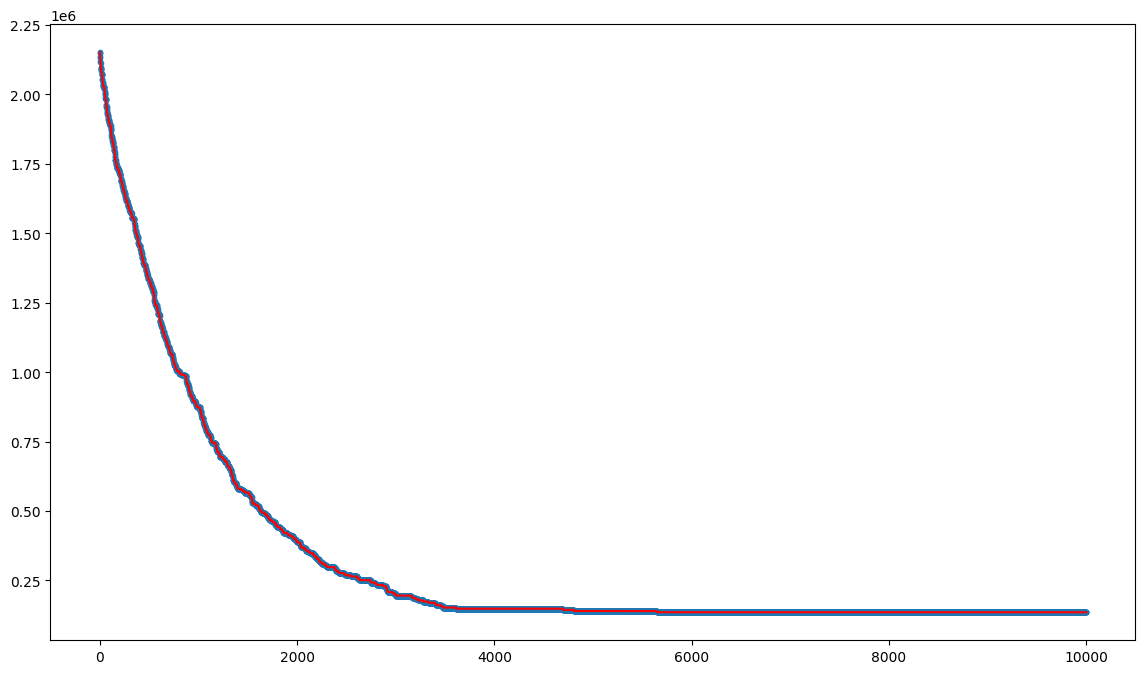

In [338]:
current_solution = rng.random(NUM_SETS) < 0.5
history = [cost(current_solution)]
ic(cost(current_solution))

steps =  0
for n in range(MAX_STEPS):
    
    steps += 1
    #tweak
  
    new_solution = tweak(current_solution)   

    if(valid(new_solution) and cost(new_solution) < cost(current_solution)):
        #ic(steps, cost(current_solution), cost(new_solution))
        current_solution = new_solution
    history.append(cost(current_solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, min)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

#ic(history.index(cost(current_solution)))
valid(current_solution), cost(current_solution)

## simulated annealing

In [318]:
def simulated_annealing(solution_fitness, new_solution_fitness, temp):
    accepting_probability = np.exp(-(solution_fitness[1] - new_solution_fitness[1]) / temp)
    #ic(solution_fitness[1] - new_solution_fitness[1])
    #ic(accepting_probability)
    return np.random.random() < accepting_probability


ic|

 solution_fiteness: (np.True_, np.float64(-2129410.1175637734))
ic| fitness(current_solution): (np.True_, np.float64(-136852.68661935194))


(np.True_, np.float64(-136852.68661935194))

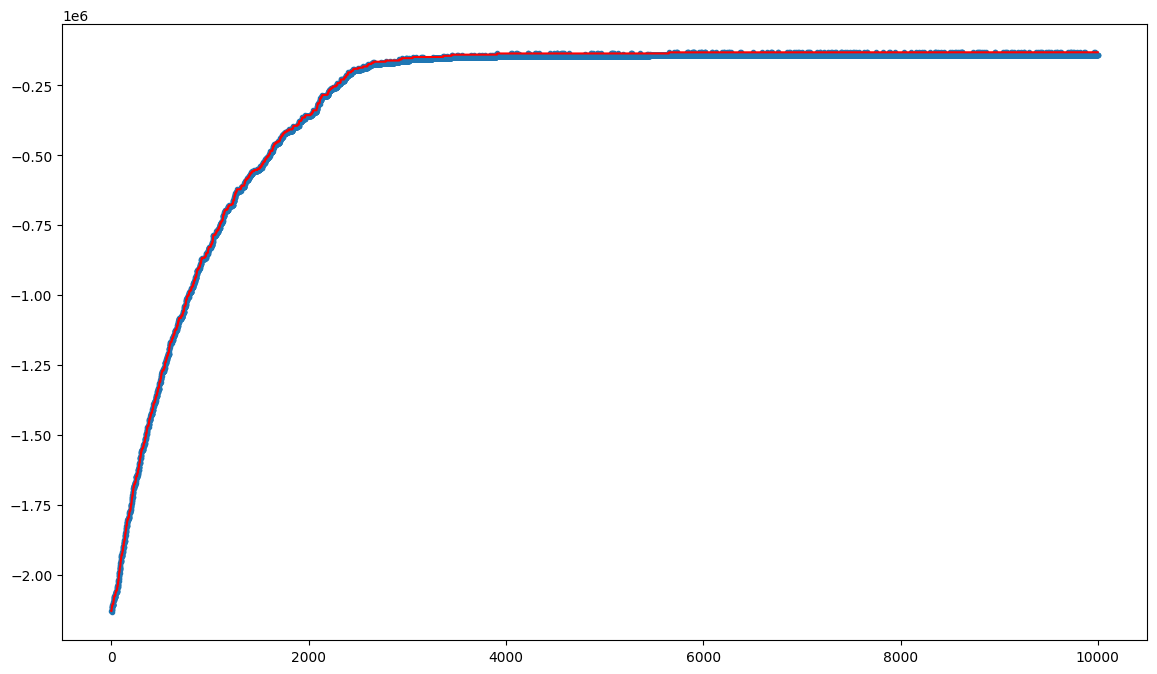

In [321]:
current_solution = rng.random(NUM_SETS) < 0.5
solution_fiteness = fitness(current_solution)
history = [solution_fiteness[1]]
ic(solution_fiteness)



temp = 1565
for steps in range(MAX_STEPS):
    #tweak 
    new_solution = single_tweak(current_solution)   
    f = fitness(new_solution)
    if(f > solution_fiteness or (f[0]  and simulated_annealing(solution_fiteness, f, temp))):
        #ic(steps, cost(current_solution), cost(new_solution))
        current_solution = new_solution
        solution_fiteness = f
    history.append(float(f[1]))
    temp*=0.99




plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

ic(fitness(current_solution))